# Rigetti

In [1]:
import sys
sys.path.append('../')
from src.analysis.EventStudy import EventStudy
from src.data.data_utils import get_returns, scrape_arxiv
from src.analysis.visualization import plot_test_results
import pandas as pd
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

In [3]:
ticker = 'RGTI'
rgti_returns = get_returns(ticker, start_date="2021-01-01", end_date="2025-10-31")
market_returns = get_returns("^GSPC", start_date=rgti_returns.index[0], end_date="2025-10-31")
arxiv_df = scrape_arxiv(query="Quantum AND Rigetti", start_date="2021-01-01")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
windows = [i for i in range(36)]

ev_rgti = EventStudy(ticker, market_returns, windows)

In [5]:
ev_rgti.fit_residuals(stock_returns=rgti_returns, window=35, expanding=True)

/Users/williamfriend/anaconda3/envs/qsig/lib/python3.13/site-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


In [6]:
filtered_dates = []
for idx in rgti_returns.index:
        if all(abs(idx - arxiv_df.index) > pd.Timedelta('10d')):
            filtered_dates.append(idx)

results = ev_rgti.event_single_test(event_dates=arxiv_df.index)
mean_random, std_random = ev_rgti.random_single_test(filtered_dates=filtered_dates, n=len(arxiv_df))

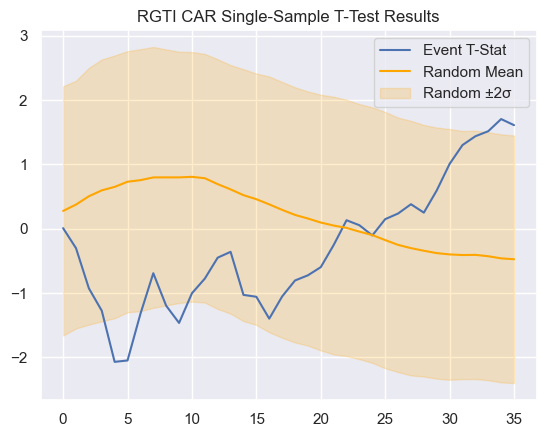

In [7]:
plot_test_results(ticker, results, mean_random, std_random, single_test=True, enable_plotly=False)

In [8]:
mean_two_sample, std_two_sample = ev_rgti.event_two_sample_test(event_dates=arxiv_df.index, filtered_dates=filtered_dates, n=len(arxiv_df))

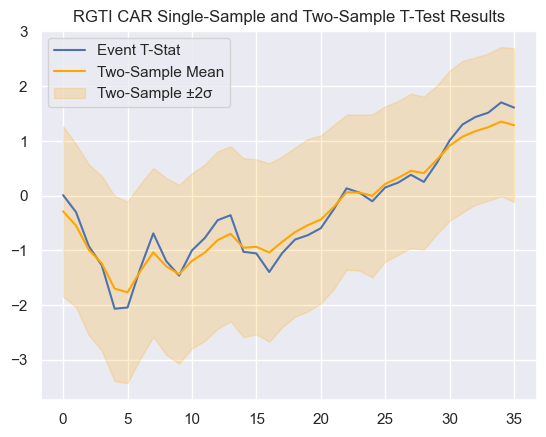

In [11]:
plot_test_results(ticker, results, mean_two_sample, std_two_sample, single_test=False, enable_plotly=False)

# Amazon

In [12]:
ticker = 'AMZN'
amzn_returns = get_returns(ticker, start_date="2021-01-01", end_date="2025-10-31")
market_returns = get_returns("^GSPC", start_date=amzn_returns.index[0], end_date="2025-10-31")
arxiv_df = scrape_arxiv(query="Quantum AND AWS Center for Quantum Computing", start_date="2021-01-01", max_results=500)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [13]:
windows = [i for i in range(36)]

ev_amzn = EventStudy(ticker, market_returns, windows)

In [14]:
ev_amzn.fit_residuals(stock_returns=amzn_returns, window=35, expanding=True)

/Users/williamfriend/anaconda3/envs/qsig/lib/python3.13/site-packages/statsmodels/regression/rolling.py:255: RuntimeWarning:

divide by zero encountered in scalar divide



In [15]:
filtered_dates = []
for idx in amzn_returns.index:
        if all(abs(idx - arxiv_df.index) > pd.Timedelta('10d')):
            filtered_dates.append(idx)

results = ev_amzn.event_single_test(event_dates=arxiv_df.index)
mean_random, std_random = ev_amzn.random_single_test(filtered_dates=filtered_dates, n=len(arxiv_df))

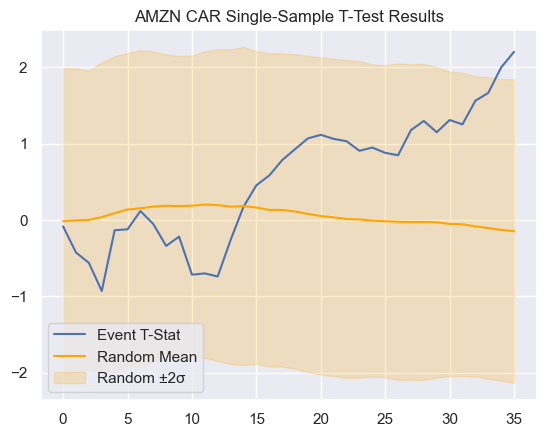

In [16]:
plot_test_results(ticker, results, mean_random, std_random, single_test=True, enable_plotly=False)

In [17]:
mean_two_sample, std_two_sample = ev_amzn.event_two_sample_test(event_dates=arxiv_df.index, filtered_dates=filtered_dates, n=len(arxiv_df))

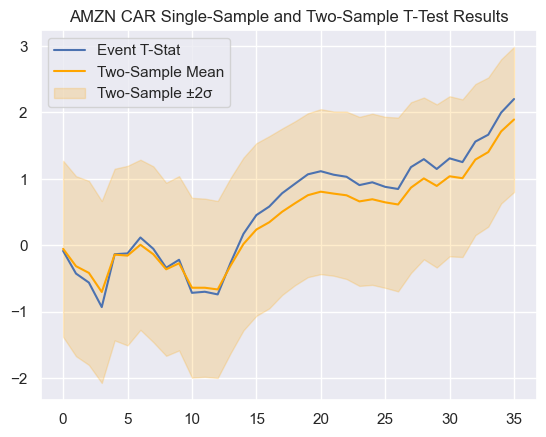

In [18]:
plot_test_results(ticker, results, mean_two_sample, std_two_sample, single_test=False, enable_plotly=False)

# D-Wave

In [2]:
ticker = 'QBTS'
dwave_returns = get_returns(ticker, start_date="2021-01-01", end_date="2025-10-31")
market_returns = get_returns("^GSPC", start_date=dwave_returns.index[0], end_date="2025-10-31")
arxiv_df = scrape_arxiv(query="Quantum AND D-Wave Quantum", start_date="2021-01-01", max_results=500)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
windows = [i for i in range(36)]

ev_dwave = EventStudy(ticker, market_returns, windows)

In [4]:
ev_dwave.fit_residuals(stock_returns=dwave_returns, window=35, expanding=True)

/Users/williamfriend/anaconda3/envs/qsig/lib/python3.13/site-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


In [ ]:
filtered_dates = []
for idx in dwave_returns.index:
        if all(abs(idx - arxiv_df.index) > pd.Timedelta('10d')):
            filtered_dates.append(idx)

results = ev_dwave.event_single_test(event_dates=arxiv_df.index)
mean_random, std_random = ev_dwave.random_single_test(filtered_dates=filtered_dates, n=len(list(set(arxiv_df.index))), replacement=True)

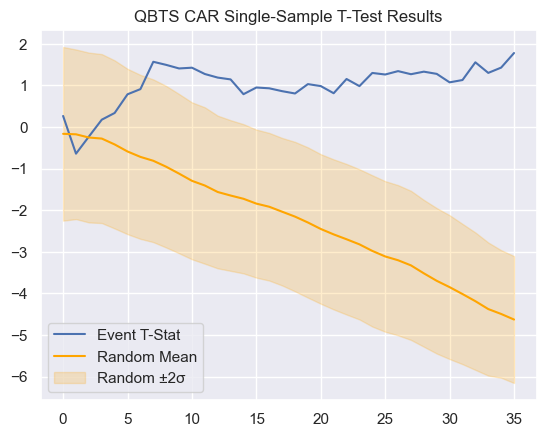

In [6]:
plot_test_results(ticker, results, mean_random, std_random, single_test=True, enable_plotly=False)

In [7]:
mean_two_sample, std_two_sample = ev_dwave.event_two_sample_test(event_dates=arxiv_df.index, filtered_dates=filtered_dates, n=len(arxiv_df), replacement=True)

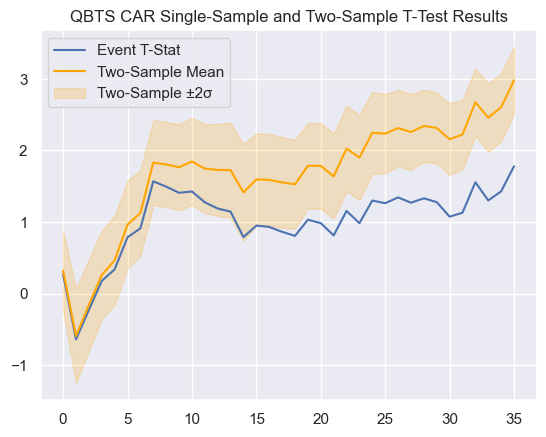

In [8]:
plot_test_results(ticker, results, mean_two_sample, std_two_sample, single_test=False, enable_plotly=False)

# IBM

In [9]:
ticker = 'IBM'
ibm_returns = get_returns(ticker, start_date="2021-01-01", end_date="2025-10-31")
market_returns = get_returns("^GSPC", start_date=ibm_returns.index[0], end_date="2025-10-31")
arxiv_df = scrape_arxiv(query="Quantum AND IBM Quantum", start_date="2021-01-01", max_results=2000)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [10]:
windows = [i for i in range(36)]

ev_ibm = EventStudy(ticker, market_returns, windows)

In [11]:
ev_ibm.fit_residuals(stock_returns=ibm_returns, window=35, expanding=True)

/Users/williamfriend/anaconda3/envs/qsig/lib/python3.13/site-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)


In [12]:
filtered_dates = []
for idx in ibm_returns.index:
        if all(abs(idx - arxiv_df.index) > pd.Timedelta('2d')):
            filtered_dates.append(idx)
            
results = ev_ibm.event_single_test(event_dates=list(set(arxiv_df.index)))
mean_random, std_random = ev_ibm.random_single_test(filtered_dates=filtered_dates, n=len(list(set(arxiv_df.index))), replacement=True)

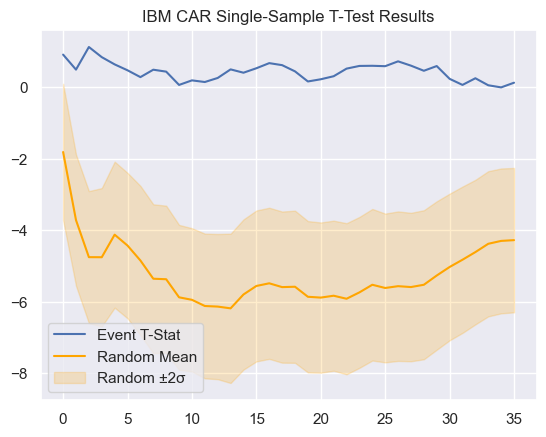

In [13]:
plot_test_results(ticker, results, mean_random, std_random, single_test=True, enable_plotly=False)

In [14]:
mean_two_sample, std_two_sample = ev_ibm.event_two_sample_test(event_dates=list(set(arxiv_df.index)), filtered_dates=filtered_dates, n=len(list(set(arxiv_df.index))), replacement=True)

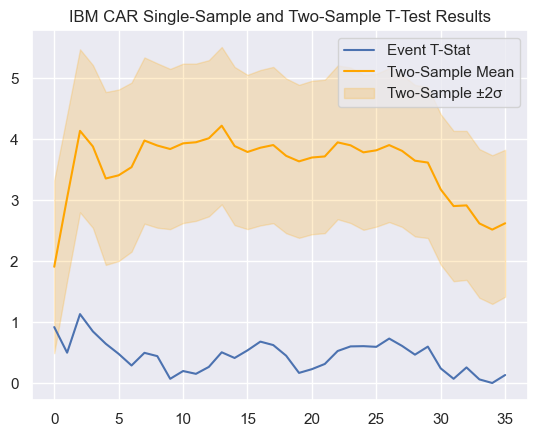

In [15]:
plot_test_results(ticker, results, mean_two_sample, std_two_sample, single_test=False, enable_plotly=False)